# 🤖 **RPA** - 📧 Mailing Automático de Reporte de Tipos de Cambio 💵

## 📚 Instalación de librerías

Para instalar correctamente los paquetes necesarios, puedes utilizar el siguiente código quitando los numerales:

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} numpy
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} seaborn
# !conda install --yes --prefix {sys.prefix} selenium
# pip install webdriver-manager

Por otra parte, también vas a necesitar el chromedriver, o el driver necesario para tu navegador web. Este Software se descarga simplemente de la web oficial, https://chromedriver.chromium.org/. Una vez descargado, se ubica en la misma ruta que el script como es en el caso del presente notebook, o dentro del script puede informar la ruta de la siguiente manera, obviamente, quitándo los numerales que convierten las líneas de código en comentarios:

In [2]:
# ruta_webdriver = r"C:\ruta\webdriver"
# driver = webdriver.Chrome(ruta_webdriver, options=chrome_options)

## 📚 Importación de librerías

In [3]:
# Manejo del tiempo para cronometrar el programa y manejar datos tipo fecha
import time
import datetime as dt
from datetime import datetime
comienzo = time.perf_counter()

# Meses en español
import locale

# Manejar datos y cálculos
import pandas as pd
import numpy as np

# Manejar APIs
import json
import requests

# Webscrapping
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Crear gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, MultipleLocator, AutoMinorLocator
import seaborn as sns

# No mostrar contraseña
from getpass import getpass

# Personalización del mail
import mimetypes
from email.message import EmailMessage
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

# Seguridad para el mailing automático
import smtplib, ssl

# Personalizar df como tabla html
from tabulate import tabulate

In [4]:
# Función para eliminar el signo peso
def eliminar_peso(x):
    x = x.lstrip('$')
    return float(x)

# Función para reemplazar la coma de un string y convertirlo a número
def reemplazar_coma(x):
    x = x.replace(',', '.')
    return float(x)

In [5]:
# Fuentes,usaremos las variables para ingresar a las webs y para citar las fuentes
web_dolarhoy = "https://dolarhoy.com/"
web_bna = "https://www.bna.com.ar/Personas"
web_ambito_mep = "https://www.ambito.com/contenidos/dolar-mep.html"
web_ambito_riesgo_pais = "https://www.ambito.com/contenidos/riesgo-pais-historico.html"
web_fed = "https://www.federalreserve.gov/releases/h15/"
web_bcra = "https://www.bcra.gob.ar/PublicacionesEstadisticas/Principales_variables.asp"
web_perfil= "https://tiempofinanciero.com.ar/cotizaciones/euro-blue/"

## 📝 Importación de Excel acumulativo 

In [6]:
ruta_bbdd = r'Seguimiento Dólar Blue.csv'
df = pd.read_csv(ruta_bbdd, index_col=0)
df

,Fecha,TCC_Blue,TCV_Blue,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,Solidario,TCV_MEP,riesgo_pais,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,Solidario / TCV Blue,TCV MEP / TCV Blue,TCV Euro / TCC Blue %,Variación Solidario,Variación TCV Blue,Variación TCV Euro
0,27/12/23,980.0,1000.0,787.25,827.25,804.40,807.40,1323.6,922.26,1866.0,1033.0,1087.0,5.33,171.46,0.323600,-0.077740,0.087000,0.000605,0.005025,0.004621
1,26/12/23,975.0,995.0,786.75,826.75,803.85,806.85,1322.8,933.65,1864.0,1027.0,1082.0,5.33,171.46,0.329447,-0.061658,0.087437,0.002729,0.000000,0.005576
2,22/12/23,975.0,995.0,784.50,824.50,801.75,804.75,1319.2,952.30,1860.0,1022.0,1076.0,5.33,171.46,0.325829,-0.042915,0.081407,0.000607,0.015306,0.015094
3,21/12/23,950.0,980.0,784.00,824.00,801.20,804.20,1318.4,957.36,1872.0,1005.0,1060.0,5.33,171.46,0.345306,-0.023102,0.081633,0.000607,-0.015075,-0.020333
4,20/12/23,965.0,995.0,783.50,823.50,800.70,803.70,1317.6,947.16,1853.0,1027.0,1082.0,5.33,171.46,0.324221,-0.048080,0.087437,0.000608,0.005051,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6448,17/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6449,16/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6450,15/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6451,14/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000


In [7]:
# # Cuando olvide el bot un día, puedo insertar datos como diccionario
# # Eliminar fila cuyo ID sea 0
# df = df.drop(0)

# new_data = {
#     "Fecha": ["13/12/23"],
#     "Solidario": [1312],
#     "TCC_Blue": [1050.0],
#     "TCV_Blue": [1070.00],
#     "TCV_MEP": [1011.46],
#     "TCC_Billete": [780.0],
#     "TCV_Billete": [820.0],
#     "TCC_Divisas": [796.95],
#     "TCV_Divisas": [799.95],
#     "TCC_Euro": [1022.0],
#     "TCV_Euro": [1076.0],
#     "fed_tea": [5.33],
#     "bcra_tea": [254.82],
#     "riesgo_pais": [1935.0]
# }

# # Convert the new data dictionary into a DataFrame
# new_data_df = pd.DataFrame(new_data)

# # Append the new data to your existing DataFrame
# data_df = pd.concat([df, new_data_df], ignore_index=True)

# # Convert the "Fecha" column to datetime with the correct format
# data_df['Fecha'] = pd.to_datetime(data_df['Fecha'], format='%d/%m/%y')

# # Now, sort the DataFrame by the "Fecha" column in descending order
# data_df.sort_values(by="Fecha", ascending=False, inplace=True)

# # Reset the index
# data_df.reset_index(drop=True, inplace=True)

# data_df['Fecha'] = data_df['Fecha'].dt.strftime("%d/%m/%y")

# # Now, data_df is sorted by the "Fecha" column in descending order with a reset index
# df = data_df
# df

## 🤖 Ingreso a la web y toma de datos 

In [8]:
# Ingreso a la web dolarhoy
driver = webdriver.Chrome("chromedriver", options=chrome_options)
driver.get(web_dolarhoy)

# Toma de datos mediante xpath
solidario = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[2]/div[6]/div/div[2]/div[2]')
blue_tcc = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[1]/div/div[1]/div[1]/div[2]')
blue_tcv = driver.find_element(
    "xpath",
    '//*[@id="home_0"]/div[2]/section/div/div/div/div[1]/div/div[1]/div/div[1]/div[2]/div[2]')

# Creación de fila nueva, la columna fecha toma la fecha de hoy y la convierte en serie de tiempo
# - dt.timedelta(days=1) para restar un día
dolar_hoy = pd.DataFrame(
    {"Fecha":dt.datetime.today(),
     "TCC_Blue":blue_tcc.text,
     "TCV_Blue":blue_tcv.text},
    index=[0])

dolar_hoy["Fecha"] = pd.to_datetime(dolar_hoy["Fecha"]).dt.strftime("%d/%m/%y")

# Eliminación de $
dolar_hoy.TCC_Blue = dolar_hoy.TCC_Blue.apply(eliminar_peso)
dolar_hoy.TCV_Blue = dolar_hoy.TCV_Blue.apply(eliminar_peso)

display(dolar_hoy)

driver.close()

,Fecha,TCC_Blue,TCV_Blue
0,28/12/23,980.0,1000.0


In [9]:
#Ingreso a la web Banco Nación
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_bna)

billete_tcc = driver.find_element(
    "xpath",
    '//*[@id="billetes"]/table/tbody/tr[1]/td[2]')
billete_tcv = driver.find_element(
    "xpath",
    '//*[@id="billetes"]/table/tbody/tr[1]/td[3]')

bna = pd.DataFrame({
    "TCC_Billete":[reemplazar_coma(billete_tcc.text)],
    "TCV_Billete":[reemplazar_coma(billete_tcv.text)]},
    index=[0])

#Cliquear botón que habilita el tipo de cambio divisas
driver.find_element(
    "xpath",
    '//*[@id="rightHome"]/div[1]/div/ul/li[2]/a').click()

#Esperar dos segundos para que aparezcan los elementos, wait.until no sirvió
time.sleep(2)

bna_tcc_divisas = driver.find_element(
    "xpath",
    '//*[@id="divisas"]/table/tbody/tr[1]/td[2]')
bna_tcv_divisas = driver.find_element(
    "xpath",
    '//*[@id="divisas"]/table/tbody/tr[1]/td[3]')
bna_divisas = pd.DataFrame(
    {"TCC_Divisas":float(bna_tcc_divisas.text),
    "TCV_Divisas":float(bna_tcv_divisas.text)},
    index=[0])

bna = pd.concat([bna,bna_divisas], axis = 1)

#Agregar dólar solidario según impuestos
impuestos_solidario = 0.6
bna["Solidario"] = bna.TCV_Billete * ( 1 + impuestos_solidario ) 

display(bna)

driver.close()

,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,Solidario
0,787.75,827.75,804.95,807.95,1324.4


In [10]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_perfil)

# tcc_euro = WebDriverWait(driver, 10).until(
#     EC.presence_of_element_located(
#         ("xpath", '//*[@id="app-body"]/main/div[1]/div/div/div[24]')
#     )
# )

# tcv_euro =  WebDriverWait(driver, 10).until(
#     EC.presence_of_element_located(
#         ("xpath", '//*[@id="app-body"]/main/div[1]/div/div/div[23]')
#     )
# )

tcc_euro = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located(
        ("xpath", '//*[@id="price-content"]/div[1]/table/tbody/tr/td[2]')
    )
)

tcv_euro =  WebDriverWait(driver, 10).until(
    EC.presence_of_element_located(
        ("xpath", '//*[@id="price-content"]/div[1]/table/tbody/tr/td[3]')
    )
)

euro = pd.DataFrame(
    {"TCC_Euro": [int(tcc_euro.text.replace(".","").replace(",",".").replace("$", ""))],
    "TCV_Euro": [int(tcv_euro.text.replace(".","").replace(",",".").replace("$", ""))]},
    index=[0]
)

display(euro)

driver.close()

,TCC_Euro,TCV_Euro
0,1033,1087


In [11]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_ambito_mep)

time.sleep(2)

mep = driver.find_element(
    "xpath",
    '/html/body/main/div/div[1]/div[1]/div/div[2]/div[1]/div/div/div[2]/span[1]')

ambito = pd.DataFrame(
    {"TCV_MEP":[reemplazar_coma(mep.text)]},
    index=[0])

driver.get(web_ambito_riesgo_pais)
time.sleep(2)

riesgo_pais = driver.find_element(
    "xpath",
    '/html/body/main/div/div[1]/div[10]/table/tbody/tr[1]/td[2]')

riesgo_pais = pd.DataFrame(
    {"riesgo_pais":[reemplazar_coma(riesgo_pais.text)]},
    index=[0])

ambito = pd.concat([ambito,riesgo_pais],axis = 1)

display(ambito)

driver.close()

,TCV_MEP,riesgo_pais
0,957.51,1894.0


In [12]:
# Ingresamos a la web de la FED para obtener la tasa de interés de EEUU
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_fed)

fed_tea = driver.find_element(
    "xpath",
    '/html/body/div[3]/div[6]/table/tbody/tr[1]/td[5]')
time.sleep(2)

fed_tea = pd.DataFrame(
{"fed_tea":[reemplazar_coma(fed_tea.text)]},
index=[0])

time.sleep(2)

driver.get(web_bcra)
time.sleep(2)

# Ingresamos a la web del BCRA para obtener la tasa de interés de Argentina 
driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.get(web_bcra)

bcra_tea = driver.find_element(
    "xpath",
    '/html/body/div/div[2]/div/div/div/div/table/tbody/tr[8]/td[3]')
time.sleep(2)

bcra_tea = pd.DataFrame(
    {"bcra_tea":[reemplazar_coma(bcra_tea.text)]},
    index=[0])

# Concatenamos las tasas para crear las columnas a agregar
tasas = pd.concat([fed_tea,bcra_tea], axis=1)

driver.close()

# Imprimimos ambos dataframes con dos renglones de diferencia
display(tasas)

,fed_tea,bcra_tea
0,5.33,171.46


In [94]:
# Obtenemos la inflación mucho más rápido mediante api que mediante scraping
base_url = "https://api.estadisticasbcra.com/"
token = string_de_tu_token_gratuito
consulta = "inflacion_mensual_oficial"
url = base_url + consulta
headers = {"Authorization": f"BEARER {token}"}
response = requests.get(url, headers=headers).json()
inflacion_df = pd.json_normalize(response)

inflacion_df.columns = ["Fecha", "Inflación"]
inflacion_df["Fecha"] = pd.to_datetime(inflacion_df["Fecha"], format="%Y-%m-%d").dt.strftime("%m/%y")
inflacion_df

,Fecha,Inflación
0,01/90,79.2
1,02/90,61.6
2,03/90,95.5
3,04/90,11.4
4,05/90,13.6
...,...,...
402,07/23,6.3
403,08/23,12.4
404,09/23,12.7
405,10/23,8.3


In [95]:
# Tomamos sólo los últimos 96 meses (8 años)
meses_ocho_años = 8 * 12
inflacion_df = inflacion_df.tail(meses_ocho_años).copy()

#A la columna inflación la dividimos por 100 para que sea %, le sumamos 1 para poder multiplicar
#Le aplicamos cumprod (multiplica acumuladamente) y le restamos el uno que sumamos para cada fila
#Lo multiplicamos por 100 para que coincida con el formato del eje Y de antes
inflacion_df["Inflación Agregada"] = ((inflacion_df["Inflación"]/100+1).cumprod()-1)*100

# Imprimir tabla con formato en porcentaje
inflacion_df.style.format(
    {
        "Inflación": "{:.2f}%",
        "Inflación Agregada": "{:.2f}%"
    }
)

,Fecha,Inflación,Inflación Agregada
311,12/15,3.90%,3.90%
312,01/16,4.10%,8.16%
313,02/16,2.70%,11.08%
314,03/16,3.00%,14.41%
315,04/16,3.40%,18.30%
316,05/16,4.20%,23.27%
317,06/16,3.10%,27.09%
318,07/16,2.00%,29.63%
319,08/16,0.20%,29.89%
320,09/16,1.10%,31.32%


In [15]:
#nueva fila final con todos los datos tomados
fila_nueva = [dolar_hoy, bna, ambito, euro, tasas]
fila_nueva = pd.concat(fila_nueva, axis=1)
fila_nueva

,Fecha,TCC_Blue,TCV_Blue,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,Solidario,TCV_MEP,riesgo_pais,TCC_Euro,TCV_Euro,fed_tea,bcra_tea
0,28/12/23,980.0,1000.0,787.75,827.75,804.95,807.95,1324.4,957.51,1894.0,1033,1087,5.33,171.46


## 🖥️ Concatenado de la nueva fila en el DataFrame acumulado 

In [16]:
# Concatenado de la fila nueva
df = pd.concat([
    fila_nueva,
    df.loc[:]
]).reset_index(drop=True)

In [17]:
# Bajo paridad de tasas de interés de Irving Fisher a 3 meses
bcra_tea_numerador = 1 + (float(df["bcra_tea"].iloc[0])/100)
fed_tea_denominador = 1 + (float(df["fed_tea"].iloc[0])/100)
division = bcra_tea_numerador / fed_tea_denominador
fwd_oficial = float(df["TCV_Billete"].iloc[0]) * division
fwd_blue = float(df["TCV_Blue"].iloc[0]) * division

In [18]:
# Crear columnas de cálculo de brechas y variación del día
df["Solidario / TCV Blue"] = df["Solidario"]/df["TCV_Blue"]-1
df["TCV MEP / TCV Blue"] = df["TCV_MEP"]/df["TCV_Blue"]-1
df["TCV Euro / TCC Blue %"] = df["TCV_Euro"]/df["TCV_Blue"]-1
df["Variación Solidario"] = df["Solidario"].pct_change(periods=-1)
df["Variación Solidario"].fillna(0, inplace=True)
df["Variación TCV Blue"] = df["TCV_Blue"].pct_change(periods=-1)
df["Variación TCV Blue"].fillna(0, inplace=True)
df["Variación TCV Euro"] = df["TCV_Euro"].pct_change(periods=-1)
df["Variación TCV Euro"].fillna(0, inplace=True)
df

C:\Users\mmartinez\AppData\Local\Temp\ipykernel_16884\3908910309.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df["Variación Solidario"] = df["Solidario"].pct_change(periods=-1)
C:\Users\mmartinez\AppData\Local\Temp\ipykernel_16884\3908910309.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df["Variación TCV Blue"] = df["TCV_Blue"].pct_change(periods=-1)
C:\Users\mmartinez\AppData\Local\Temp\ipykernel_16884\3908910309.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df["Variación TC

,Fecha,TCC_Blue,TCV_Blue,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,Solidario,TCV_MEP,riesgo_pais,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,Solidario / TCV Blue,TCV MEP / TCV Blue,TCV Euro / TCC Blue %,Variación Solidario,Variación TCV Blue,Variación TCV Euro
0,28/12/23,980.0,1000.0,787.75,827.75,804.95,807.95,1324.4,957.51,1894.0,1033.0,1087.0,5.33,171.46,0.324400,-0.042490,0.087000,0.000604,0.000000,0.000000
1,27/12/23,980.0,1000.0,787.25,827.25,804.40,807.40,1323.6,922.26,1866.0,1033.0,1087.0,5.33,171.46,0.323600,-0.077740,0.087000,0.000605,0.005025,0.004621
2,26/12/23,975.0,995.0,786.75,826.75,803.85,806.85,1322.8,933.65,1864.0,1027.0,1082.0,5.33,171.46,0.329447,-0.061658,0.087437,0.002729,0.000000,0.005576
3,22/12/23,975.0,995.0,784.50,824.50,801.75,804.75,1319.2,952.30,1860.0,1022.0,1076.0,5.33,171.46,0.325829,-0.042915,0.081407,0.000607,0.015306,0.015094
4,21/12/23,950.0,980.0,784.00,824.00,801.20,804.20,1318.4,957.36,1872.0,1005.0,1060.0,5.33,171.46,0.345306,-0.023102,0.081633,0.000607,-0.015075,-0.020333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6449,17/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6450,16/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6451,15/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6452,14/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000


## 💾 Exportar a CSV

In [19]:
df.to_csv(ruta_bbdd)

## 📈 Gráficos para adjuntar en el mail

In [80]:
# Tomamos las primeras filas que querramos mostrar y las primeras 14 columnas, es decir, sin variaciones
cotizaciones_a_mostrar = 25
# Copia del dataframe, para no reemplazarlo
data = df.copy()
# Damos vuelta el dataframe sólo para los gráficos
# Si no lo damos vuelta, los gráficos van a empzar de hoy hacia atrás
data = data.iloc[::-1]
data

,Fecha,TCC_Blue,TCV_Blue,TCC_Billete,TCV_Billete,TCC_Divisas,TCV_Divisas,Solidario,TCV_MEP,riesgo_pais,TCC_Euro,TCV_Euro,fed_tea,bcra_tea,Solidario / TCV Blue,TCV MEP / TCV Blue,TCV Euro / TCC Blue %,Variación Solidario,Variación TCV Blue,Variación TCV Euro
6453,11/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6452,14/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6451,15/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6450,16/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
6449,17/12/98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,21/12/23,950.0,980.0,784.00,824.00,801.20,804.20,1318.4,957.36,1872.0,1005.0,1060.0,5.33,171.46,0.345306,-0.023102,0.081633,0.000607,-0.015075,-0.020333
3,22/12/23,975.0,995.0,784.50,824.50,801.75,804.75,1319.2,952.30,1860.0,1022.0,1076.0,5.33,171.46,0.325829,-0.042915,0.081407,0.000607,0.015306,0.015094
2,26/12/23,975.0,995.0,786.75,826.75,803.85,806.85,1322.8,933.65,1864.0,1027.0,1082.0,5.33,171.46,0.329447,-0.061658,0.087437,0.002729,0.000000,0.005576
1,27/12/23,980.0,1000.0,787.25,827.25,804.40,807.40,1323.6,922.26,1866.0,1033.0,1087.0,5.33,171.46,0.323600,-0.077740,0.087000,0.000605,0.005025,0.004621


C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  wi

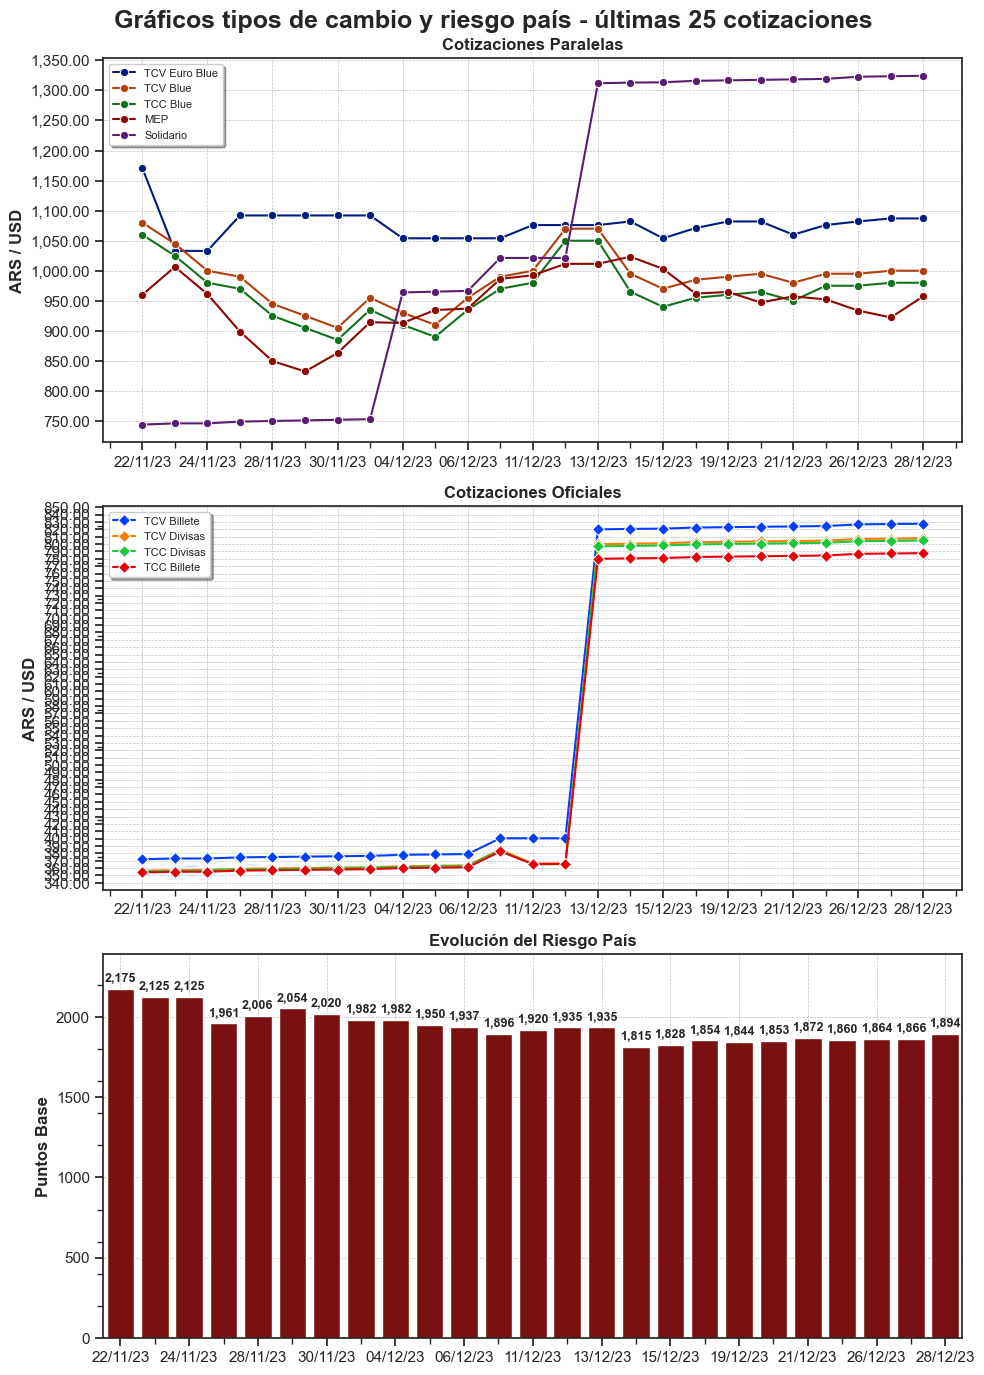

In [81]:
# Creo un subplot de 3 gráficos verticales
fig, ax = plt.subplots(
    3, 1,
    figsize=(10, 14),
    sharex=False
)

# Estilo de gráfico, con ticks en X e Y
sns.set(style="ticks")

titulos = [
    "Cotizaciones Paralelas",
    "Cotizaciones Oficiales",
    "Evolución del Riesgo País",
]

ax0_palette = sns.color_palette("dark")

ax0_columns = [
    "TCV_Euro",
    "TCV_Blue",
    "TCC_Blue",
    "TCV_MEP",
    "Solidario"
]
ax0_labels = [
    "TCV Euro Blue",
    "TCV Blue",
    "TCC Blue",
    "MEP",
    "Solidario"
]

# Títulos general y para cada gráfico
fig.suptitle(
    f"Gráficos tipos de cambio y riesgo país - últimas {cotizaciones_a_mostrar} cotizaciones",
    fontweight="bold",
    fontsize=18
)
for i, titulo in enumerate(titulos):
    ax[i].set_title(
        titulo,
        fontweight="bold",
        fontsize=12
    )

for i, column in enumerate(ax0_columns):
    sns.lineplot(
        x="Fecha",
        y=column,
        data=data.tail(cotizaciones_a_mostrar),
        label=ax0_labels[i],
        color=ax0_palette[i],
        marker="o",
        ax=ax[0],
    )

# Gráfico de cotizaciones oficiales
ax1_palette = sns.color_palette("bright")
ax1_columns = [
    "TCV_Billete",
    "TCV_Divisas",
    "TCC_Divisas",
    "TCC_Billete"
]
ax1_labels = [
    "TCV Billete",
    "TCV Divisas",
    "TCC Divisas",
    "TCC Billete"
]
for i, column in enumerate(ax1_columns):
    sns.lineplot(
        x="Fecha",
        y=column,
        data=data.tail(cotizaciones_a_mostrar),
        label=ax1_labels[i],
        color=ax1_palette[i],
        marker="D",
        ax=ax[1],
    )

# Gráfico de barras del riesgo país
sns.barplot(
    x="Fecha",
    y="riesgo_pais",
    data=data.tail(cotizaciones_a_mostrar),
    label="Riesgo País",
    color="darkred",
    ax=ax[2],
)

# Agregamos etiquetas de datos a las barras
for i, bar in enumerate(ax[2].containers[0].get_children()[-len(data.riesgo_pais) :]):
    height = bar.get_height()
    ax[2].annotate(
        f"{height:,.0f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontproperties=fm.FontProperties(weight="bold", size=9),
    )

# Consolidate the formatting of x-axis
for axis in ax:
    axis.set_xlabel("")
    axis.xaxis.set_major_locator(MultipleLocator(2))
    axis.xaxis.set_minor_locator(MultipleLocator(1))

# y separador de miles, por si la inflación se va demasiado, ya estoy adelantado
for i in range(2):
    ax[i].yaxis.set_major_formatter(FuncFormatter("{:,.2f}".format))

# Títulos y ticks eje Y
y_labels = ["ARS / USD", "ARS / USD", "Puntos Base"]
y_major_locators = [
    MultipleLocator(50),
    MultipleLocator(10),
    MultipleLocator(500)
]
y_minor_locators = [
    MultipleLocator(250),
    MultipleLocator(25),
    MultipleLocator(200)
]
for i in range(3):
    ax[i].set_ylabel(
        y_labels[i],
        fontsize = 12,
        fontweight="bold"
    )
    ax[i].yaxis.set_major_locator(y_major_locators[i])
    ax[i].yaxis.set_minor_locator(y_minor_locators[i])

# Límites eje Y
ax[2].set_ylim([0, data.tail(cotizaciones_a_mostrar).riesgo_pais.max() * 1.1])

# Le damos estilo al grid del fondo
grid_estilo = {"color": "silver", "linestyle": "--", "linewidth": 0.5}
for axis in ax:
    axis.grid(**grid_estilo)

ax[0].legend(prop={'size': 8}, shadow=True)
ax[1].legend(prop={'size': 8}, shadow=True)
   
# Guardamos el gráfico como imagen .jpg para enviarla por mail
fig.tight_layout(pad=1)
graficos_jpg = "Gráficos Tipos de Cambios y Riesgo País.jpg"
plt.savefig(graficos_jpg)

C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  wi

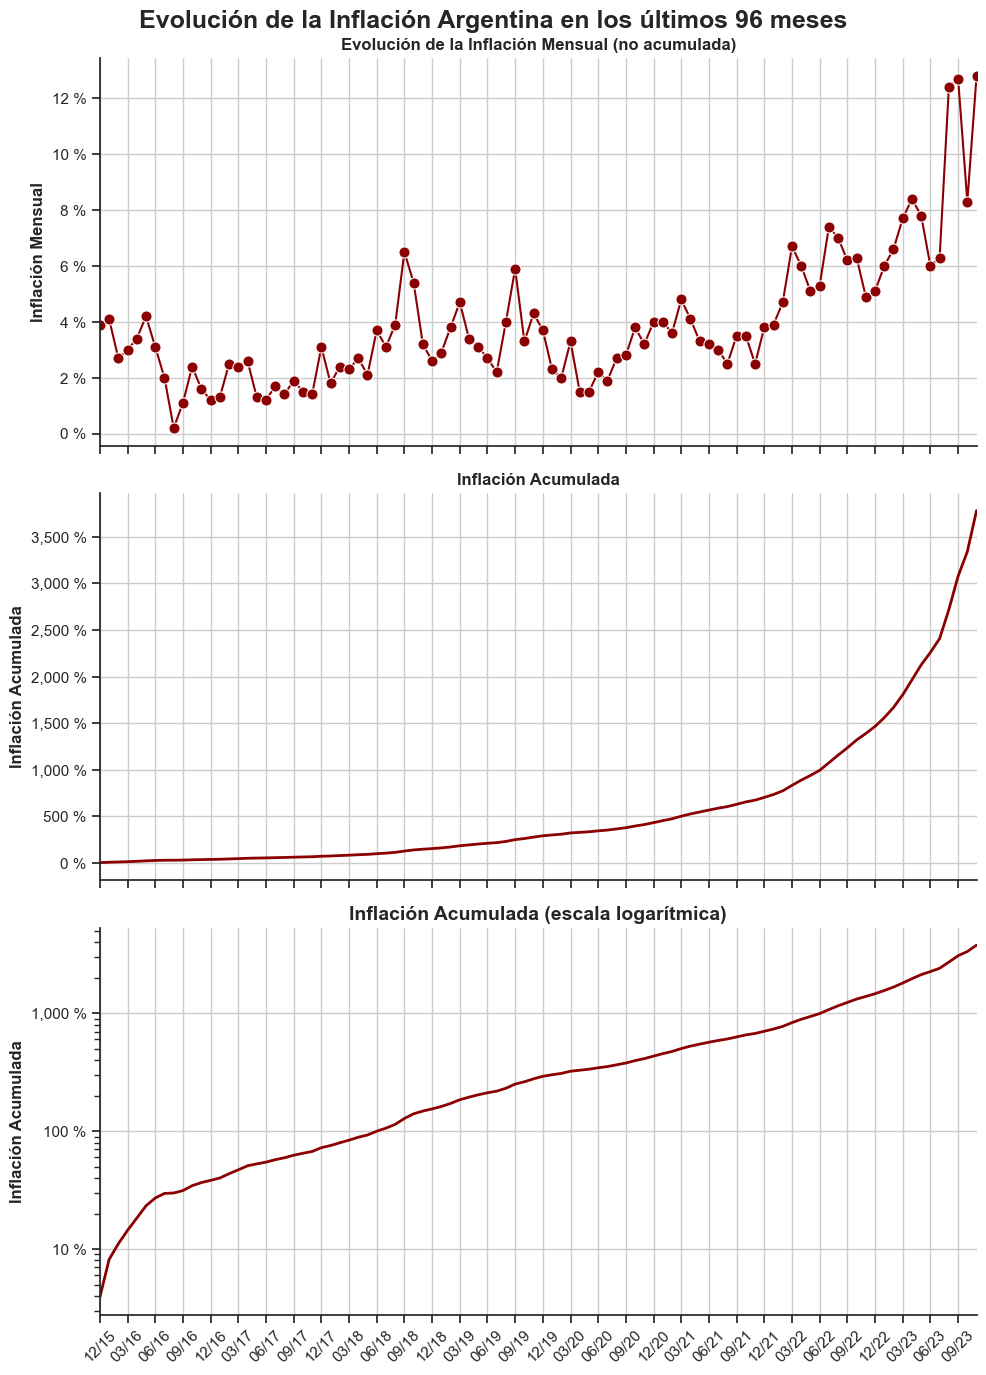

In [82]:
# Crear un subplot con tres gráficos verticales
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

fig.suptitle(
    f"Evolución de la Inflación Argentina en los últimos {meses_ocho_años} meses",
    fontweight="bold",
    fontsize=18
)

# Gráfico inflación mensual NO ACUMULADA
sns.lineplot(
    x="Fecha",
    y="Inflación",
    data=inflacion_df,
    color="darkred",
    marker='o',
    markersize=8,
    ax=axes[0]
)

# Configurar los ticks del eje X para mostrar cada 3 meses
axes[0].set_xticks(range(0, meses_ocho_años, 3))
axes[0].set_xticklabels(inflacion_df.Fecha[::3], rotation=45)
axes[0].set_xlim(0, meses_ocho_años - 1)

axes[0].set_title(
    "Evolución de la Inflación Mensual (no acumulada)",
    fontweight="bold",
    fontsize=12
)
axes[0].set_ylabel(
    "Inflación Mensual",
    fontweight="bold",
    fontsize=12
)
axes[0].set_xlabel("")

axes[0].yaxis.set_major_formatter(FuncFormatter("{:,.0f} %".format))
axes[0].grid(True)
sns.despine()

# Gráfico inflación mensual ACUMULADA
sns.lineplot(
    x="Fecha",
    y="Inflación Agregada",
    data=inflacion_df,
    color="darkred",
    linewidth=2,
    legend=False,
    ax=axes[1]
)

# Configurar los ticks del eje X para mostrar cada 6 meses
axes[1].set_xticks(range(0, meses_ocho_años, 6))
axes[1].set_xticklabels(inflacion_df.Fecha[::6], rotation=45)
axes[1].set_xlim(0, meses_ocho_años - 1)

axes[1].set_title(
    "Inflación Acumulada",
    fontweight="bold",
    fontsize=12
)
axes[1].set_ylabel(
    "Inflación Acumulada",
    fontweight="bold",
    fontsize=12
)

axes[1].yaxis.set_major_formatter(FuncFormatter("{:,.0f} %".format))
axes[1].grid(True)
sns.despine()

# Gráfico inflación mensual ACUMULADA logarítmica
sns.lineplot(
    x="Fecha",
    y="Inflación Agregada",
    data=inflacion_df,
    color="darkred",
    linewidth=2,
    ax=axes[2]
).set_yscale("log")  # Escala logarítmica en el eje Y

# Configurar los ticks del eje X para mostrar cada 3 meses
axes[2].set_xticks(range(0, meses_ocho_años, 3))
axes[2].set_xticklabels(inflacion_df.Fecha[::3], rotation=45)
axes[2].set_xlim(0, meses_ocho_años - 1)
axes[2].set_xlabel("")

axes[2].set_title(
    "Inflación Acumulada (escala logarítmica)",
    fontweight="bold",
    fontsize=14
)
axes[2].set_ylabel(
    "Inflación Acumulada",
    fontweight="bold",
    fontsize=12
)

axes[2].yaxis.set_major_formatter(FuncFormatter("{:,.0f} %".format))
axes[2].grid(True)
sns.despine()

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Guardamos el gráfico como imagen .jpg para enviarla por mail
fig.tight_layout(pad=1)

inflacion_jpg = "Gráficos Inflación.jpg"
plt.savefig(inflacion_jpg)

# Mostrar el gráfico
plt.show()

C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmartinez\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

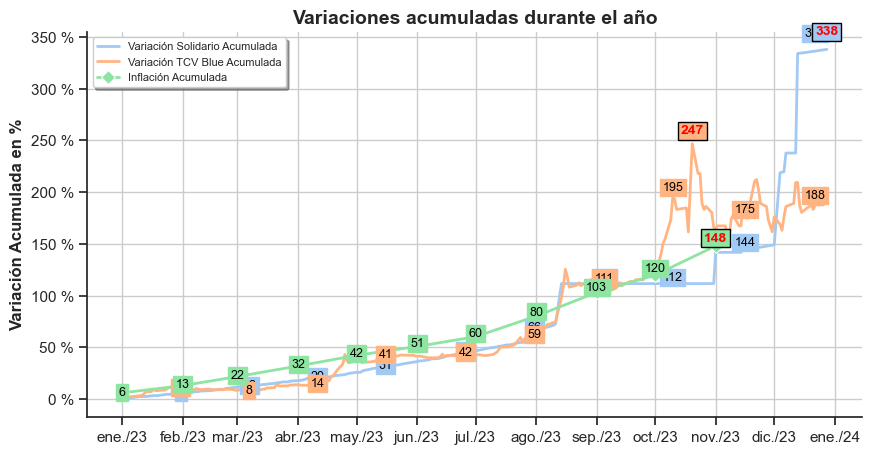

In [83]:
locale.setlocale(locale.LC_TIME, 'es_ES.utf8')

inflacion_df["Fecha"] = pd.to_datetime(inflacion_df["Fecha"], format="%m/%y")

data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%y")

variacion_acumulada = data.merge(inflacion_df[["Fecha","Inflación"]], on=["Fecha"], how="outer")

#Ordenamos por fecha ya que luego del merge, pone al final las fechas sin cotización pero con inflación
variacion_acumulada.sort_values("Fecha", inplace=True)

# Filtramos por el año actual
current_year = pd.Timestamp.today().year

#Damos vuelta el dataset
variacion_acumulada = variacion_acumulada[variacion_acumulada["Fecha"].dt.year == current_year]

variacion_acumulada.loc[:, "Fecha"] = pd.to_datetime(variacion_acumulada["Fecha"], format="%d-%m-%y")

#Creamos las columnas acumulativas
columns_to_cumulate = ['Variación Solidario', 'Variación TCV Blue', 'Inflación']
for column in columns_to_cumulate:
    if column == 'Inflación':
        variacion_acumulada[f'{column} Acumulada'] = ((1 + variacion_acumulada[column] / 100).cumprod()-1)*100
    else:
        variacion_acumulada[f'{column} Acumulada'] = ((1 + variacion_acumulada[column]).cumprod()-1)*100

        
fig, ax = plt.subplots(figsize=(10, 5))

# Gráfico de cotizaciones oficiales
palette = sns.color_palette("pastel")
ax2_columns = [
    "Variación Solidario Acumulada",
    "Variación TCV Blue Acumulada",
    "Inflación Acumulada"
]
ax2_labels = [
    "Δ Solidario Acumulada",
    "Δ TCV Blue Acumulada",
    "Inflación Acumulada"
]

for i, column in enumerate(ax2_columns):

    if column == "Inflación Acumulada":
        sns.lineplot(
            x="Fecha",
            y=column,
            data=variacion_acumulada,
            label=ax2_labels[i],
            color=palette[i],
            linewidth=2,
            marker="D",
            markersize=7
        )
    else:
        sns.lineplot(
            x="Fecha",
            y=column,
            data=variacion_acumulada,
            label=ax2_columns[i],
            color=palette[i],
            linewidth=2
        )

    # Etiqueta de datos para cada línea, se requieren diferentes frecuencias
    bbox = dict(facecolor=palette[i], alpha=1, edgecolor=palette[i], boxstyle='square,pad=0.2')
    label_frequency = 25 if column != "Inflación Acumulada" else 1
    for idx, row in variacion_acumulada.iterrows():
        if not pd.isna(row[column]):
            # Etiquetar según frecuencia correspondiente
            if idx % label_frequency == 0:
                plt.text(
                    row['Fecha'],
                    row[column]*1.05,
                    f'{row[column]:,.0f}',
                    fontsize=9,
                    color="black",
                    ha="center",
                    va="center",
                    bbox=bbox
                )

            # Etiqueta del valor máximo por línea/columna
            bbox_max = dict(facecolor=palette[i], alpha=1, edgecolor="black", boxstyle='square,pad=0.2')
            if row[column] == variacion_acumulada[column].max() and idx == variacion_acumulada[column].idxmax():
                plt.text(
                    row['Fecha'],
                    row[column]*1.05,
                    f'{row[column]:,.0f}',
                    fontsize=10,
                    color="red",
                    fontweight="bold",
                    ha="center",
                    va="center",
                    bbox=bbox_max
                )

ax.set_title("Variaciones acumuladas durante el año", fontsize=14, fontweight="bold")

# Formatear eje de X
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b/%y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Mostrar un tick al mes

# Formatear eje de Y
ax.yaxis.set_major_formatter(FuncFormatter("{:,.0f} %".format))
ax.set_xlabel("")
ax.set_ylabel("Variación Acumulada en %", fontsize = 12, fontweight="bold")

plt.grid(True)
sns.despine()

variaciones_jpg = "Variaciones.jpg"
plt.savefig(variaciones_jpg)

plt.legend(prop={'size': 8}, shadow=True)
plt.show()

## 📮 Mailing automático

In [97]:
# Tomamos sólo los últimos 12 meses para ver la interanual y
inflacion_df = inflacion_df[["Fecha", "Inflación"]].tail(12).copy()
inflacion_df["Fecha"] = pd.to_datetime(inflacion_df["Fecha"], format="%m/%y").dt.strftime("%m/%y")

# Calcula la inflación interanual
inflacion_df["Inflación Interanual"] = (
  (inflacion_df["Inflación"] / 100 + 1)
  .rolling(window=12, min_periods=12)
  .apply(np.prod, raw=True)
  - 1
) * 100

# Tomamos el último valor de inflación interanual, para informar en el cuerpo del mail
inflacion_interanual = inflacion_df["Inflación Interanual"].iloc[-1]
inflacion_interanual =  "{0:,.2f}%".format(inflacion_interanual)

inflacion_df["Inflación"] = inflacion_df["Inflación"] / 100

# Inflación en ventanas de tres meses
inflacion_df["Inflación Trimestral"] = (
    (inflacion_df["Inflación"] / 100 + 1)
    .rolling(window=3) # Trimestral
    .apply(np.prod, raw=True)
    - 1
) * 100

# Cambiar a tipo string y rellenar los nan con -
inflacion_df["Inflación Interanual"].fillna(0, inplace=True)
inflacion_df["Inflación Trimestral"].fillna(0, inplace=True)


# Imprimir tabla con formato en porcentaje
inflacion_df

,Fecha,Inflación,Inflación Interanual,Inflación Trimestral
395,12/22,0.051,0.000000,0.000000
396,01/23,0.060,0.000000,0.000000
397,02/23,0.066,0.000000,0.177104
398,03/23,0.077,0.000000,0.203137
399,04/23,0.084,0.000000,0.227171
400,05/23,0.078,0.000000,0.239190
401,06/23,0.060,0.000000,0.222163
402,07/23,0.063,0.000000,0.201134
403,08/23,0.124,0.000000,0.247190
404,09/23,0.127,0.000000,0.314316


In [102]:
# Declaración de variables, para que funcione tu contraseña de gmail, tenés que tener una contraseña para app
# si no tenés, se crea en esta página myaccount.google.com
email_sender = input("Tipeá tu usuario de gmail:")
email_password = getpass("Tipeá tu contraseña:")

email_receiver = [
    lista_correos
]

# Descomentar la siguiente línea para testear
# email_receiver = email_sender

# Tabular los días a mostrar del dataframe para que se vea en el cuerpo del mail
cotizaciones = [
    "Fecha",
    "tccblue",
    "tcvblue",
    "tccBillete",
    "tcvBillete",
    "tccDivisas",
    "tcvDivisas",
    "Solidario",
    "MEP",
    "RiesgoPaís",
    "tccEuros",
    "tcvEuros",
    "FEDtea",
    "BCRAtea"
]

# Valores correspondientes a los últimos días, 14 columnas
valores = df.iloc[:cotizaciones_a_mostrar, :14].values.tolist()
tabla_cotizaciones = tabulate(
    valores,
    headers=cotizaciones,
    tablefmt = "html",
    numalign="center",
    floatfmt=".2f"
)

# Encabezados para tabular últimos 10 días del df y ponerlo en el cuerpo
variaciones = [
    "Fecha",
    "Solidario/TCV_Blue",
    "MEP/TCV_Blue",
    "Euro_Blue/Dólar_Blue",
    "Variación_Solidario",
    "Variación_Blue",
    "Variación_Euro"
]
# Valores correspondientes a los últimos días, 14 columnas
valores = df.iloc[:cotizaciones_a_mostrar, [0] + list(range(14, df.shape[1]))].values.tolist()
tabla_variaciones = tabulate(
    valores,
    headers=variaciones,
    tablefmt="html",
    numalign="center",
    floatfmt=".2%"
)

# Encabezados para tabular últimos 10 días del df y ponerlo en el cuerpo
inflaciones = [
    "Fecha",
    "Inflación Mensual",
    "Inflación Trimestral"
]
# Valores correspondientes a los últimos días, 14 columnas
valores = inflacion_df[["Fecha", "Inflación", "Inflación Trimestral"]].values.tolist()
tabla_inflacion = tabulate(
    valores,
    headers=inflaciones,
    tablefmt="html",
    numalign="center",
    floatfmt=".2%"
)

# Cuerpo del texto con código html
html = f"""<!DOCTYPE html>
<html lang="es">
   <head>
      <meta charset="UTF-8">
      <meta http-equiv="X-UA-Compatible" content="IE=edge">
      <meta name="viewport" content="width=device-width, initial-scale=1.0">
   </head>
   <body>
      <p> 📅 <b><u>Resumen diario: </u></b> ℹ️<br></p>
      <p>
         <b>Costo comprar USD 200 blue 💰:</b> $ {(float(df["TCV_Blue"].iloc[0] * 200)):,.2f} <br>
         <b>Costo comprar USD 200 oficiales con impuestos:</b> $ {(float(df["Solidario"].iloc[0] * 200)):,.2f}<br>
         <b>La diferencia es de:</b> $ {(float(df["TCV_Blue"].iloc[0] * 200 - df["Solidario"].iloc[0] * 200)):,.2f}<br><br>
         <b>La brecha entre solidario y blue es:</b> {float((1 - df["Solidario"].iloc[0] / df["TCV_Blue"].iloc[0]) * 100):.2f}%<br>
         <b>El dólar solidario varió:</b> {float(((df["Solidario"].iloc[0] / df["Solidario"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>El dólar blue varió 💵:</b> {float(((df["TCV_Blue"].iloc[0] / df["TCV_Blue"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>El dólar divisas varió:</b> {float(((df["TCV_Divisas"].iloc[0] / df["TCV_Divisas"].iloc[1] - 1) * 100)):.2f}%<br><br>
         <b>El euro varió un 💶:</b> {float(((df["TCV_Euro"].iloc[0] / df["TCV_Euro"].iloc[1] - 1) * 100)):.2f}%<br>
         <b>Entre euro blue y dólar blue hay una brecha de:</b> {(1-df["TCV_Blue"].iloc[0]/df["TCV_Euro"].iloc[0])*100:.2f}%<br><br>
         <b>El valor del dólar oficial futuro según paridad de tasas de interés es:</b> $ {fwd_oficial:,.2f}<br>
         <b>El valor del dólar blue futuro según paridad de tasas de interés es 💸:</b> ${fwd_blue:,.2f}<br>
         <b>El riesgo país hoy es de ☣️:</b> {(float(df["riesgo_pais"].iloc[0])):,.0f}, es decir que Argentina debe pagar un {(float(df["riesgo_pais"].iloc[0] / 100)):.2f}% de sobretasa respecto a un bono del tesoro estadounidense.
      </p>
      <img src='cid:image1'>
      <img src='cid:image2'>
      <img src='cid:image3'>
      <p>Las siguientes tablas muestran las últimas {cotizaciones_a_mostrar} cotizaciones de dólares, euro, riesgo país y TEA del BCRA 🇦🇷 y TEA de la FED 🇺🇸.<br>
      Analizalas mientras te cebás unos mates 🧉:<br>
      </p>
      {tabla_cotizaciones}<br>
      {tabla_variaciones}<br>
      <p>La siguiente tabla muestra las últimas 12 publicaciones de la inflación, tené en cuenta que la interanual es de {inflacion_interanual}:<br>
      </p>
      {tabla_inflacion}<br>
      <p><b><u>📚Las fuentes consultadas fueron:</u>
      <b><br>Cotizaciones oficiales: </b>{web_bna}
      <b><br>Cotizaciones paralelas y Solidario: </b>{web_dolarhoy}
      <b><br>Cotización Dólar MEP: </b>{web_ambito_mep}
      <b><br>Riesgo País: </b>{web_ambito_riesgo_pais}
      <b><br>Cotización Euro Blue: </b>{web_perfil}
      <b><br>Tasa Efectiva Anual EEUU: </b>{web_fed}
      <b><br>Tasa Efectiva Anual e Inflación Argentina: </b>{web_bcra}<br>
      </p>
      <p>
         🤓 Muchas gracias por leer,<br>
         🤑 Ojalá te sirva,<br><br>
      <p> 
         👨🏽‍💼 En Linkedin encontrá mi historial laboral, académico y mis aportes en datos y comercio internacional: <b>https://linkedin.com/in/mauroemartinez/</b> <br>
         👨🏽‍💻 Encontrá en GitHub mis proyectos. ¡Incluso este!: <b>https://github.com/mauroemartinez/</b><br><br>
         🤖<i> Este es un mail automático creado por <b>Mauro E. Martinez</b>, cuya ejecución duró ⏰ {time.perf_counter() - comienzo:.2f} segundos. Escriba a martinezmauroezequiel@gmail.com ante cualquier duda, feedback, desuscripción u ofertas de colaboración.
      </p>
      </p>  
   </body>
</html>"""

# Crear el objeto MIMEMultipart y asignarle los campos
# A los receptores los ubico en Cco para que no se vean entre sí
em = MIMEMultipart('related')
em['From'] = email_sender
em["To"] = email_sender
em['Cco'] = ', '.join(email_receiver)
em["Subject"] = f"📈 Reporte automático de tipos de cambio  💱 - {dt.datetime.today():%d-%m-%Y} 📧"

# Crear el cuerpo del mensaje como un objeto MIMEText y adjuntarlo al objeto MIMEMultipart
body = MIMEText(html, 'html')
em.attach(body)

# Crear una lista con los nombres de los archivos a adjuntar
archivos_adjuntos = [graficos_jpg, inflacion_jpg, variaciones_jpg]
# Iterar a través de la lista y adjuntar cada uno
for archivo in archivos_adjuntos:
    with open(archivo, 'rb') as fp:
        msgImage = MIMEImage(fp.read())
    # Definir ID de la imagen, tal como en el html, adjuntar
    msgImage.add_header('Content-ID', f'<image{archivos_adjuntos.index(archivo) + 1}>')
    msgImage.add_header('Content-Disposition', 'attachment', filename=archivo)
    em.attach(msgImage)

# # Adjuntar .csv
# bd_filename = 'Seguimiento Dólar Blue.csv'
# with open(bd_filename, 'r') as fp:
#     bd_data = fp.read()
# bd = MIMEText(bd_data, 'csv')
# bd.add_header('Content-Disposition', 'attachment', filename=bd_filename)
# em.attach(bd)

# Crear un contexto SSL y establecer una conexión SMTP segura con el servidor de correo
context = ssl.create_default_context()
with smtplib.SMTP_SSL(
    "smtp.gmail.com",
    465,
    context=context) as smtp:
    smtp.login(
        email_sender,
        email_password
        )
    smtp.sendmail(
        email_sender,
        email_receiver,
        em.as_string()
        )

# # para outlook
# context = ssl.create_default_context()
# with smtplib.SMTP("smtp-mail.outlook.com", 587) as server:
#     server.ehlo()
#     server.starttls(context=context)
#     server.ehlo()
#     server.login(email_sender, email_password)
#     server.sendmail(email_sender, email_receiver, em.as_string())

print(f"La duración de la ejecución total fue de: {time.perf_counter() - comienzo:.2f} segundos")

La duración de la ejecución total fue de: 4806.69 segundos
